# Import

In [107]:
import multiprocessing
from tqdm import tqdm
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from gwpy.timeseries import TimeSeries
import os
import numpy as np
import pandas as pd
import h5py as h5
from os import listdir
import torch

# Load Data from Database

In this section, we load the gwpy TimeSeries dataset from h5 files as a pnadas df

In [3]:
def construct_dataframe(path, channel_list=None, target_channel='V1:Hrec_hoft_16384Hz', n1_events=None, n2_events=None, n1_channels=None, n2_channels=None, print_=True, sr=False):
    """
    Construct a DataFrame from data stored in HDF5 files.

    Parameters:
    - path (str): The directory path where the HDF5 files are located.
    - channel_list (list): A list of channel names to include in the DataFrame. If not provided, it defaults to None, and the code will load all channels in the file.
    - target_channel (str): The target channel to include in the DataFrame. Default value is 'V1:Hrec_hoft_16384Hz'.
    - n1_events (int): The starting index of events to consider. Default value is None, which corresponds to first file in directory.
    - n2_events (int): The ending index of events to consider. Default value is None, which corresponds to last file in directory.
    - n1_channels (int): The starting index of channels to consider. Default value is None, which corresponds to first channel in file.
    - n2_channels (int): The ending index of channels to consider. Default value is None, which corresponds to last channel in directory.
    - print_ (bool): A boolean indicating whether to print progress information. Default value is True.
    - sr (float or bool): New sample rate for resampling the data. Default value is False, which stands for no resampling.

    Returns:
    - DataFrame: A pandas DataFrame containing the data from the HDF5 files.
    """

    # Set default values for event and channel indices if not provided
    if not n1_events:
        n1_events = 0
    if not n2_events:
        n2_events = len(listdir(path))
    
    # Ensure n2_events does not exceed the total number of files in the directory
    if n2_events > len(listdir(path)):
        n2_events = len(listdir(path))
    
    # Get the list of files in the specified directory
    lstdr = listdir(path)[n1_events:n2_events]
    
    # Print the list of files being processed if print_ is True
    if print_:
        print(f'LIST DIR: {lstdr}')
    
    # Extract the name of a sample file from the directory
    sample_file = listdir(path)[0]
    
    # Create a list of files to process
    files = [f for f in lstdr]
    
    # Initialize lists to store DataFrame and event data
    df_list = []
    event_data = []
    
    # If channel_list is not provided, get all channels from the first HDF5 file
    if not channel_list:
        n_all_channels = 0
        all_channels = []
        with h5.File(os.path.join(path, sample_file), 'r') as fout:
            event_id = list(fout.keys())[0]
            all_channels = list(fout[event_id])
            n_all_channels = len(list(fout[event_id]))
        
        # Set default values for channel indices if not provided
        if not n1_channels:
            n1_channels = 0
        if not n2_channels:
            n2_channels = n_all_channels
        
        # Ensure n2_channels does not exceed the total number of channels
        if n2_channels > n_all_channels:
            n2_channels = n_all_channels
        
        # Select channels based on provided indices
        channels = all_channels[n1_channels:n2_channels]
    else:
        channels = channel_list
    
    # Remove the target channel from the list of channels
    try:
        channels.remove(target_channel)
    except:
        pass
    
    # Iterate over each file and extract data
    for i, file in enumerate(files):
        if print_:
            print(f"Added {i + 1}/{n2_events - n1_events} files to dataframe", end='\r')
       
        try:
            # Open the HDF5 file
            with h5.File(os.path.join(path, file), 'r') as fout:
                event_id = list(fout.keys())[0]
                dictionary = {'Event ID': event_id}
                event_data.append(event_id)
                
                # Extract data for the target channel
                tmsrs = TimeSeries(fout[event_id][target_channel], dt=1.0 / fout[event_id][target_channel].attrs['sample_rate'])
                
                # Resample the data if required
                if sr:
                    tmsrs.resample(sr)
                
                dictionary[target_channel] = [tmsrs]
                
                # Extract data for each channel
                for i, channel in enumerate(channels):
                    try:
                        tmsrs = TimeSeries(fout[event_id][channel], dt=1.0 / fout[event_id][channel].attrs['sample_rate'])
                        if sr:
                            tmsrs.resample(sr)
                        dictionary[channel] = [tmsrs]
                    except Exception as e:
                        # Handle errors in extracting data
                        tmsrs = np.nan
                        dictionary[channel] = [tmsrs]
                
                # Convert the dictionary to a DataFrame and append to df_list
                df_list.append(pd.DataFrame(dictionary))
        
        except Exception as e:
            # Handle errors in opening files
            if print_:
                print(f'COULD NOT OPEN {os.path.join(path, file)}')
                print(e)
    
    # Concatenate all DataFrames in df_list into a single DataFrame
    df = pd.concat(df_list, ignore_index=True)
    
    return df


In [4]:
h5_path='/data/datasets/intertwin-dati-aux/gspy_O3a_Scattered_Light_V1'
channel_list=['V1:Hrec_hoft_16384Hz','V1:LSC_MICH_ERR','V1:LSC_NE_CORR','V1:LSC_PR_CORR']
sr=500.0
target_channel='V1:Hrec_hoft_16384Hz'
n1_events=None
n2_events=5
n1_channels=None
n2_channels=None
print_=True

In [6]:
df=construct_dataframe(h5_path, channel_list=channel_list, target_channel=target_channel, n1_events=n1_events, n2_events=n2_events, n1_channels=n1_channels, n2_channels=n2_channels, print_=print_, sr=sr)

LIST DIR: ['DdncGnx3ph.h5', 'aGfr6y328R.h5', 'sgak4NOpls.h5', '6lKwnIbrf9.h5', 'YBjpyixbjw.h5']


# Preprocess Data

In this section we preprocess the TimeSeries Data

## Normalise data

Noralising the Timeseries to the range [0,1] before taking their q_transform should avoid under/overflow errors

In [12]:
def normalize_data(entry):
    mx=abs(entry.value).max()
    return entry/mx

In [47]:
df.iloc[:,1:]=df.iloc[:,1:].applymap(lambda t: normalize_data(t))

In [48]:
df.head()

,Event ID,V1:Hrec_hoft_16384Hz,V1:LSC_MICH_ERR,V1:LSC_NE_CORR,V1:LSC_PR_CORR
0,DdncGnx3ph,[TimeSeries(-0.51769851\n unit: dime...,[TimeSeries(0.4557494\n unit: dimens...,[TimeSeries(0.82073784\n unit: dimen...,[TimeSeries(0.5619594\n unit: dimens...
1,aGfr6y328R,[TimeSeries(0.01832472\n unit: dimen...,[TimeSeries(0.17863071\n unit: dimen...,[TimeSeries(0.19256455\n unit: dimen...,[TimeSeries(-0.6874894\n unit: dimen...
2,sgak4NOpls,[TimeSeries(0.0188897\n unit: dimens...,[TimeSeries(-0.23031014\n unit: dime...,[TimeSeries(0.37132132\n unit: dimen...,[TimeSeries(0.27148542\n unit: dimen...
3,6lKwnIbrf9,[TimeSeries(0.32464052\n unit: dimen...,[TimeSeries(-0.12203227\n unit: dime...,[TimeSeries(-0.21236621\n unit: dime...,[TimeSeries(-0.40720144\n unit: dime...
4,YBjpyixbjw,[TimeSeries(-0.44608519\n unit: dime...,[TimeSeries(0.08522085\n unit: dimen...,[TimeSeries(0.4803171\n unit: dimens...,[TimeSeries(0.07113338\n unit: dimen...


# Create Dataset

In this section, we create the qplot dataset. This is done wih the help of three functions:
1. **process_image** that takes in rows of he pandas df of preprocessed TimeSeries and computes the respective q_transforms, which are then fed to
2. **cut_image** that take in q_transforms and cuts them in chunks of desired width
3. **generate_cut_image_dataset** that governs the other two and saves the data in the desired format

In [112]:
def process_image(row,row_idx,channels,frange=(5,100),time_window=1.0):
    """
    Processes df's row to generate qplot images
    
    Input:
    - row (pd.Series) : row of TimeSeries Dataframe
    - row_idx (int) : index relative to row in DataFrame
    - frange (tuple): frequency range for q_transform. Default value (5,100)Hz.
    - time_window (float): width of cutting window in seconds. Default value 1s.
    
    Return:
    df_row (DataFrame): Row containing qplot images as 2D np.array
    """
    
    
    res_list=[]
    df_row=pd.DataFrame(columns=channels)
    channels.remove('Event ID')
    
    for i,channel in enumerate(channels):
        
        qplot =row[channel].q_transform(frange=frange)
        
        # Cut spectrogram
        qplot_array_cut= cut_image(qplot,time_window=time_window)
        df_row[channel]=qplot_array_cut
        
    event_id_list=[]    
    for j in range(len(qplot_array_cut)):
        event_id_list.append(row['Event ID'])
    df_row['Event ID']=event_id_list
                   
    return df_row


In [86]:
import math
def cut_image(qplot_array,time_window=1.0):
    """
    Cut qplot as square_size X square_size 2D np.array centered at peak frequency and corresponding time
    
    Input:
    - qplot_array (np.array) : qplot relative to the whole TimeSeries
    - n_chunks (int) : number of equally sized images to split the qplot into. Defalut = 6
    
    Return:
    - subarray (np.array) : qplot cutted as square_size X square_size np.array
       
    """
    dt=qplot_array.dt.value
    #convert spectrogram to numpy:
    qplot_array = qplot_array.value
    
    
    chunks = []
    n_rows, n_cols = qplot_array.shape
    n_chunks=math.ceil(n_rows/time_window*dt)
    
    # Iterate over rows in steps of time_window
    for i in range(n_chunks):
        if i<n_chunks-1:
            chunk = qplot_array[int(i*time_window/dt):int((i+1)*time_window/dt), :]
        else:
            chunk = qplot_array[int(i*time_window/dt):, :]
        
        # Pad last chunk if necessary
        if chunk.shape[0] < time_window:
            padding = np.zeros((time_window - chunk.shape[0], n_cols), dtype=qplot_array.dtype)
            chunk = np.vstack((chunk, padding))
        
        chunks.append(np.flipud(chunk.T))
    
    return chunks


In [111]:
def generate_cut_image_dataset(df,channels,out_dir,save_name,num_processes=20,frange=(5,100),time_window=1.0,to_torch=True):
    """
    Generates qplot dataset taking pandas df containing main+aux channels as input.
    The output is a df containing qtransforms (frequency range 5-100Hz) in the form of a 2d np.array. In the process, it saves the cut q_transforms as .h5 files.
    
    
     Parameters:
        - df (DataFrame): DataFrame containing Main and Aux channels' gwpy TimeSeries (Main channel is always first).
        - channels (list): Name of columns in the DataFrame.
        - out_dir (str): out directory to store cut qplots into.
        - num_processes (int): Number of cores for multiprocess (default 20)
        - frange (int): frequency range for q_transforms. Defalut (5,100)Hz
        - time_window (float): time window (in seconds) to cut cut image. Default value is 1s.
    
    Returns:
        - DataFrame: Pandas DataFrame containing the q_transform np.array data.
    """
    args = [(df.iloc[row],row,channels,frange,time_window) for row in range(df.shape[0])]
    with multiprocessing.Pool(processes=num_processes) as pool:
        # Use map to pass multiple arguments to process_image
        results = list(tqdm(pool.starmap(process_image, args), total=len(args)))

    df = pd.concat(results, ignore_index=True)
    
    if to_torch==True:
        print('Converting to torch...')
        df.iloc[:,1:].applymap(lambda x: torch.tensor(x))
        
    print('Saving dataset...')
    df.to_pickle(f'{out_dir}/{save_name}.pkl')
        
    return df

In [114]:
s=time.time()
df_img=generate_cut_image_dataset(df,list(df.columns),'/home/jovyan','prova_img_dataset',num_processes=20,frange=(5,100),time_window=1.0)
e=time.time()
print(e-s)

100%|██████████| 5/5 [00:00<00:00, 14237.28it/s]


Converting to torch...
Saving dataset...
2.65167236328125


# Visualise Dataset

Optional, run and play with it if you want to visualise the qplot dataset 

In [103]:
def plot_spectrogram_from_numpy(qplot_array,iter=None,total=None):
    # Plot the downsampled spectrogram
    title='Qplot cut'
    if iter and total:
        title=title + ' '+str(iter)+'/'+str(total)
    plt.figure(figsize=(6, 6))
    plt.imshow(qplot_array, aspect='auto',vmin=0,vmax=25)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.colorbar()
    plt.show()

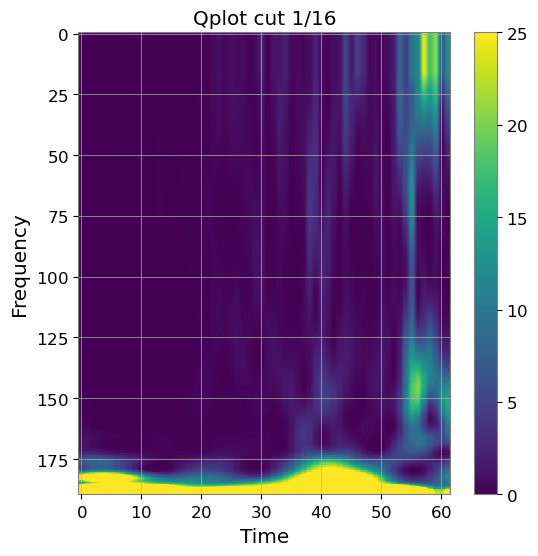

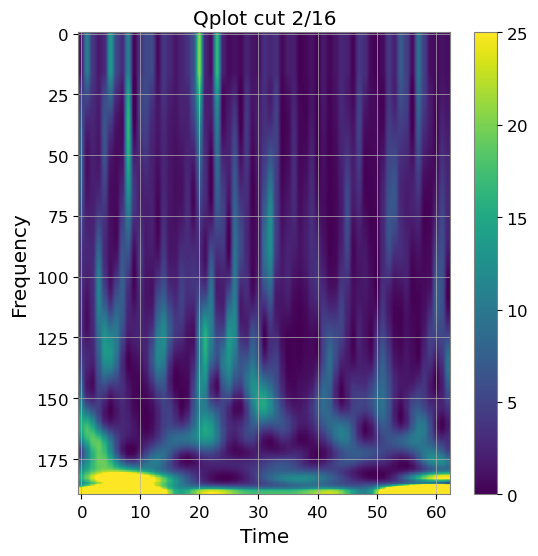

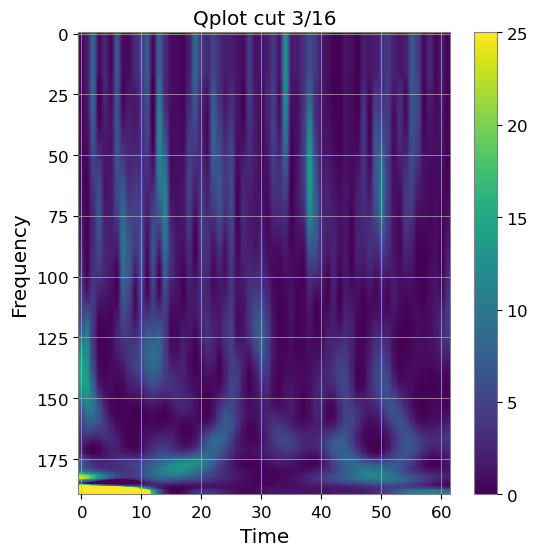

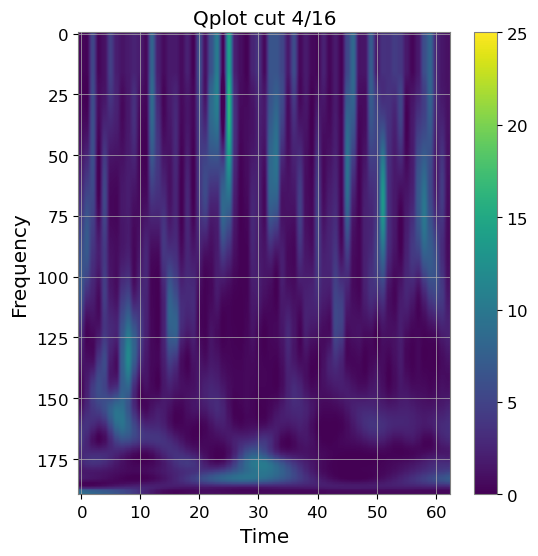

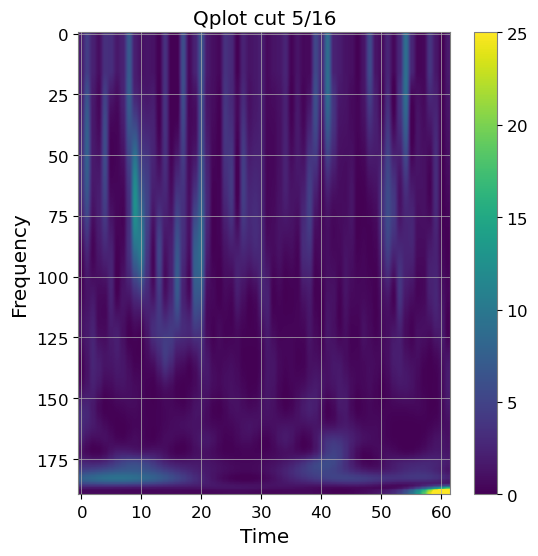

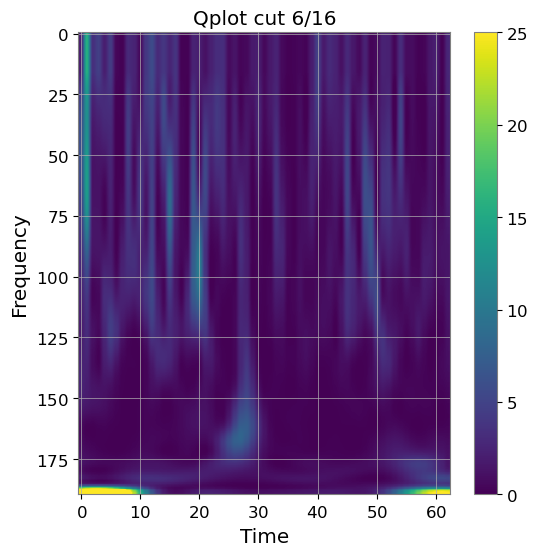

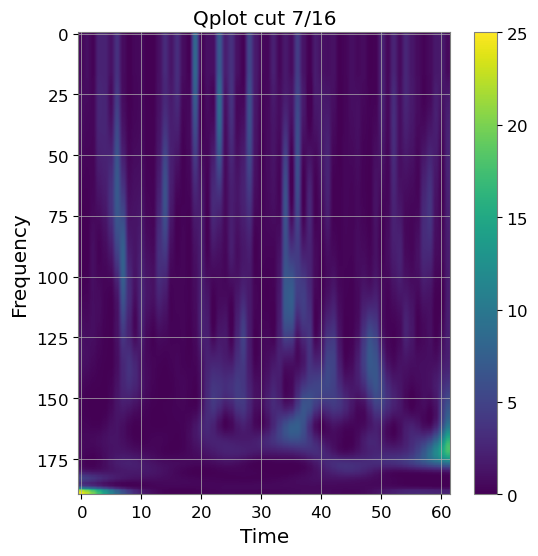

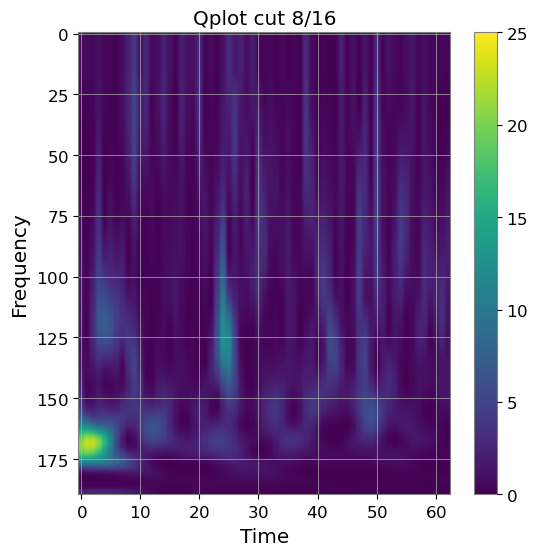

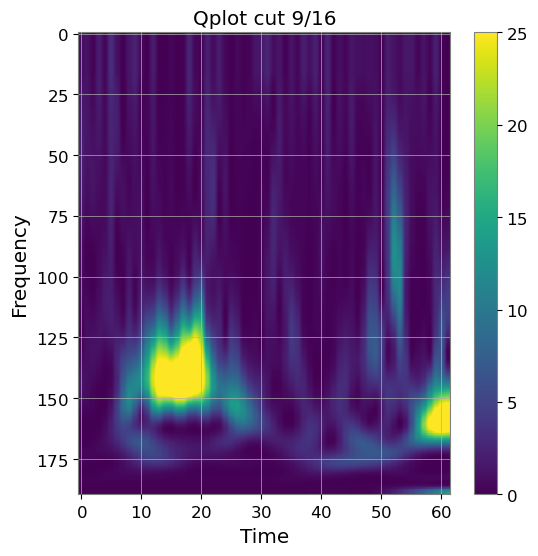

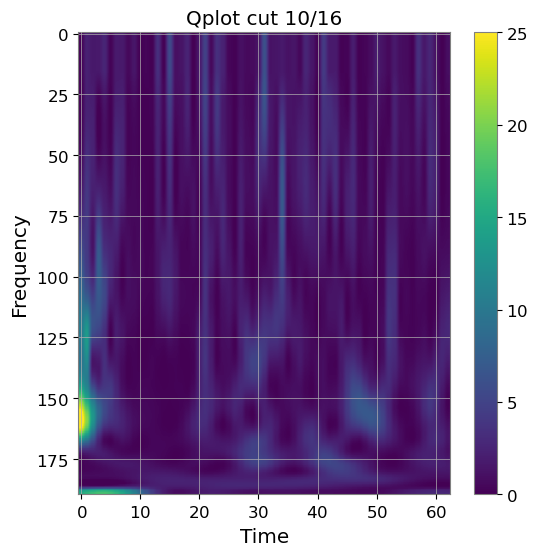

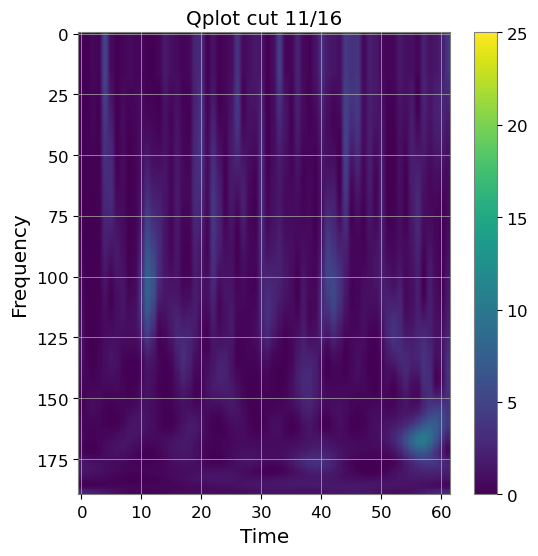

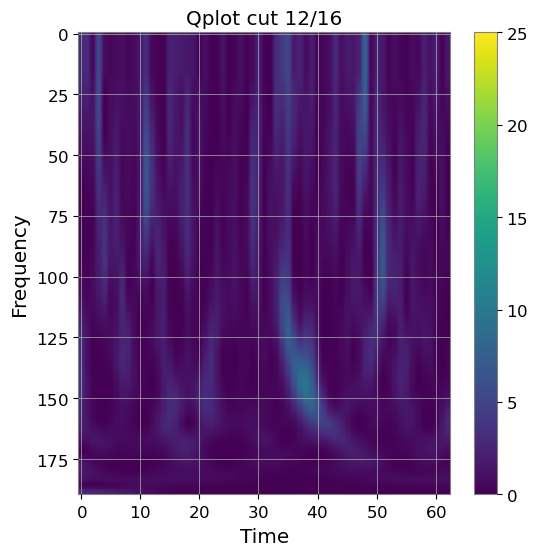

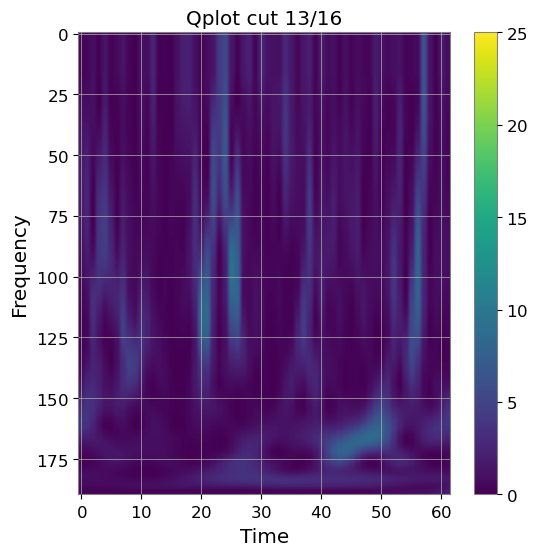

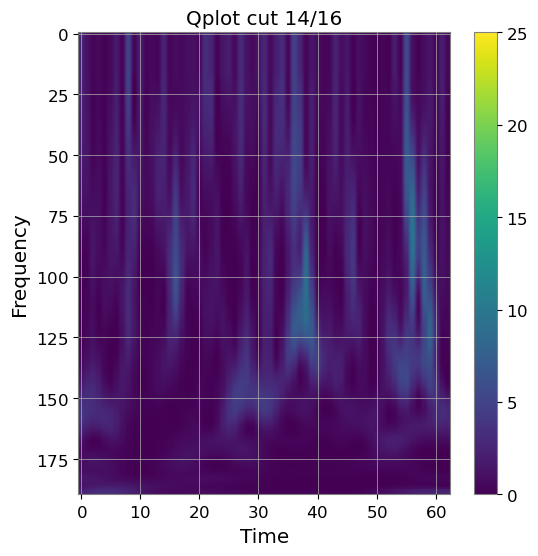

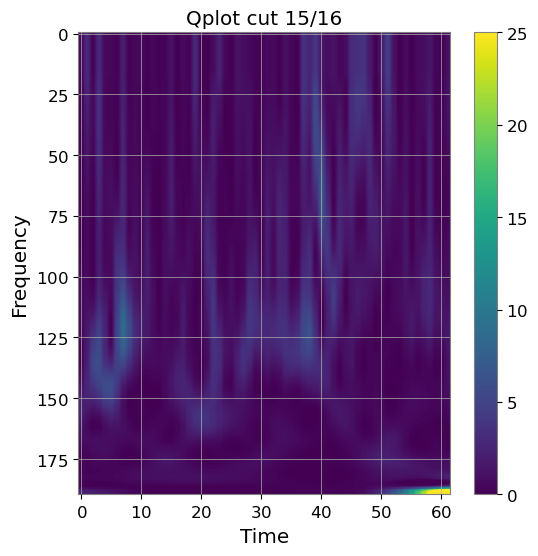

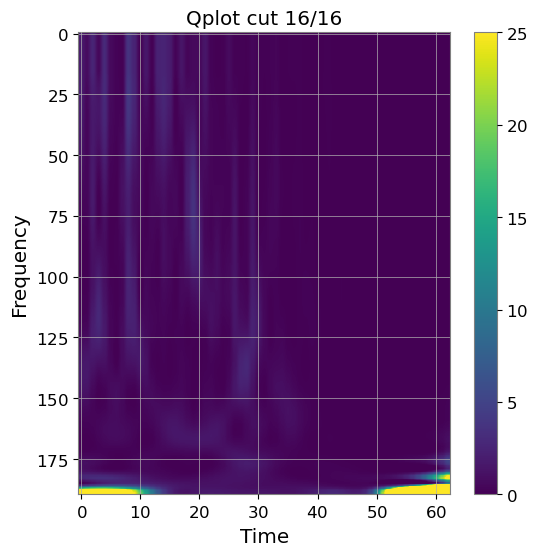

In [104]:
for i in range(16):
    plot_spectrogram_from_numpy(df_img.iloc[i,1],i+1,16)

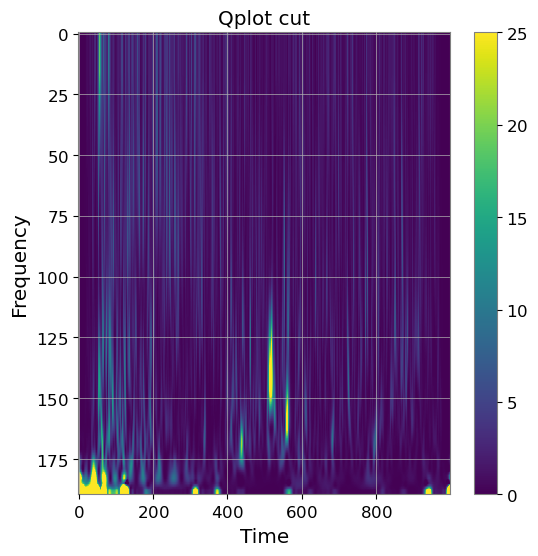

In [94]:
whole=df.iloc[0,1].q_transform(frange=(5,100))
plot_spectrogram_from_numpy(np.flipud(whole.value.T))

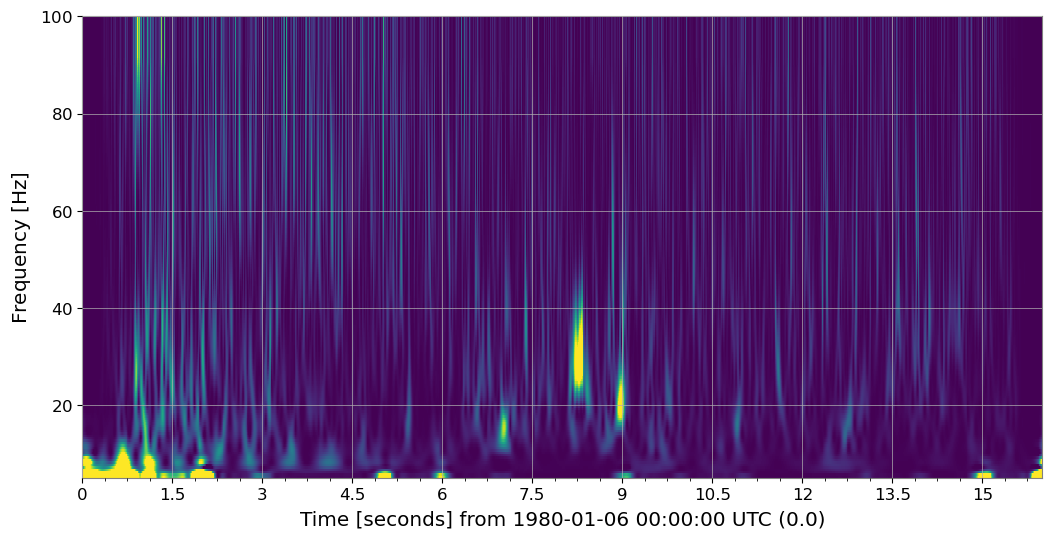

In [99]:
whole.plot(vmin=0,vmax=25)
plt.show()